In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as slinalg
%matplotlib inline

import sys
sys.path.append('../../module')
import gym2

In [46]:
env = gym2.make('Linear-v0')
Q = .01 * np.eye(2)
R = .01 * np.eye(1)
lam = 1.

In [56]:
def array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    exp[~np.eye(exp.shape[0],dtype=bool)] = 0
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out


def next_state(state, action, tau, env):
    # next state when const action and tau is input
    A = env.A
    B = env.B
    eAt = array_exp(A*tau)
    A_inv = np.linalg.inv(A)
    
    integral = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
    s_prime = np.dot(eAt, state) + integral *action 
    
    return s_prime
    
    
def control_law(state, env, Q=Q, R=R, l=lam):
    A = env.A
    B = env.B
    next_value_weight = 100
    
    taus = np.linspace(.01, 1., 100)
    evaluation = np.inf
    
    # riccati
    P = slinalg.solve_continuous_are(A, B.reshape(B.shape[0],1), Q, R)
    A_inv = np.linalg.inv(A)
    
    for tau in taus:
        # calculate optimal action with fixed `tau`
        eAt = array_exp(A*tau)
        
        # ∂s'/∂u
        dsdu = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
        # int exp(A(t-τ))Budt
        integral = dsdu

        # ∂c/∂u = first + second * u, c: instant cost
        first = 2 * np.dot(np.dot(dsdu, P), np.dot(eAt, state))
        first *= next_value_weight
        second = 2 * np.dot(np.dot(dsdu, P), integral)
        second = next_value_weight * second + 2

        # optimal action
        u = - first / second
        
        # evaluation
        s_prime = next_state(state, u, tau, env)
        ev = u**2 - l * tau + next_value_weight * np.dot(np.dot(s_prime, P), s_prime)
        #print(s_prime, ev, [u, tau])
        if ev < evaluation:
            control = np.array([u, tau])
            evaluation = ev
    
    return control

def control_law2(state, env, Q=Q, R=R, l=lam):
    # hard to calculate
    A = env.A
    B = env.B
    
    taus = np.linspace(.01, 1., 100)
    evaluation = np.inf
    
    # riccati
    P = slinalg.solve_continuous_are(A, B.reshape(B.shape[0],1), Q, R)
    A_inv = np.linalg.inv(A)
    AA_inv = np.linalg.inv(A+A.T)
    
    for tau in taus:
        # calculate optimal action with fixed `tau`
        eAt = array_exp(A*tau)
        
        # ∂s'/∂u
        dsdu = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
        # int exp(A(t-τ))Budt
        integral = dsdu
        # int exp(At)dt
        integral1 = A_inv - np.dot(A_inv, array_exp(-A*tau))
        # int exp(A^Tt)exp(At)dt
        integral2 = AA_inv - np.dot(AA_inv, array_exp(-(A+A.T)*tau))

        # ∂c/∂u = first + second * u, c: instant cost
        first = 2 * np.dot(np.dot(dsdu, P), np.dot(eAt, state)) + 2 * np.dot(np.dot(state, integral2), np.dot(integral1, B))
        second = 2 * np.dot(np.dot(dsdu, P), integral) + 2 + 2 * np.dot(np.dot(integral1, B), np.dot(integral1, B))

        # optimal action
        u = - first / second
        
        # evaluation
        s_prime = next_state(state, u, tau, env)
        
        tmp = state + np.dot(integral1, B) * u
        transition = np.dot(np.dot(tmp, integral2), tmp)
        ev = transition + u**2 - l * tau + np.dot(np.dot(s_prime, P), s_prime)
        #print(s_prime, ev, [u, tau])
        if ev < evaluation:
            control = np.array([u, tau])
            evaluation = ev
    
    return control

In [57]:
state = np.array([3.,3.])
control_law(state, env)

array([-1.52416014,  1.        ])

In [58]:
# 時々0じゃないところに行くのは何事？

[ 0.65569112 -1.3690052 ]
[3 3]
[3 3] -1.5241601432633363 1.0
[ 0.99619883 -0.40012792] -0.15157680513044497 1.0
[ 0.10264279 -0.04506411] -0.01464333066055773 1.0
[ 0.00994875 -0.00440186] -0.0014106896683447766 1.0
[ 0.00095874 -0.00042452] -0.00013586379414804874 1.0
[ 9.23392588e-05 -4.08897261e-05] -1.3084714472064969e-05 1.0
[ 8.89299918e-06 -3.93803195e-06] -1.260153954185662e-06 1.0
[ 8.56461297e-07 -3.79261743e-07] -1.2136203476848567e-07 1.0
[ 8.24834843e-08 -3.65256811e-08] -1.1688050539395709e-08 1.0
[ 7.94376213e-09 -3.51768996e-09] -1.1256446493010395e-09 1.0
[ 7.65042323e-10 -3.38779240e-10] -1.0840780264540194e-10 1.0


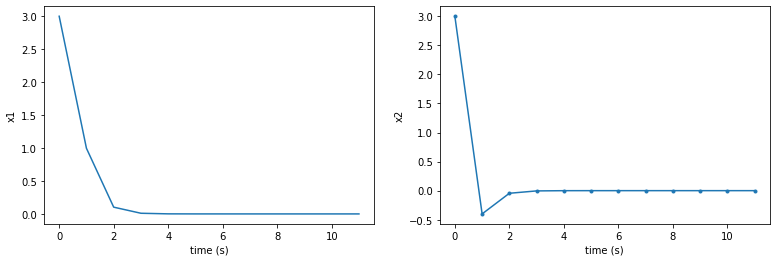

In [62]:
l = .1
env.reset()
print(env.state)
i_state = np.array([3,3])
env.set_state(i_state)
print(env.state)
states = []
time_limit = 10
time_log = [0]
actions = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append(x)
    a_agent, tau = control_law(x, env, l=l)
    actions.append([a_agent, tau])
    print(x, a_agent, tau)
    acc_time += tau
    time_log.append(acc_time)
    env.set_state(next_state(x, a_agent, tau, env))
    if acc_time > time_limit:
        break
states.append(env.state)
actions.append(control_law(env.state, env, l=l))
states = np.array(states)
actions = np.array(actions)

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.xlabel('time (s)')
plt.ylabel('x1')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('time (s)')
plt.ylabel('x2')
plt.plot(time_log, states[:,1])
plt.scatter(time_log, states[:,1], marker='.')
plt.show()

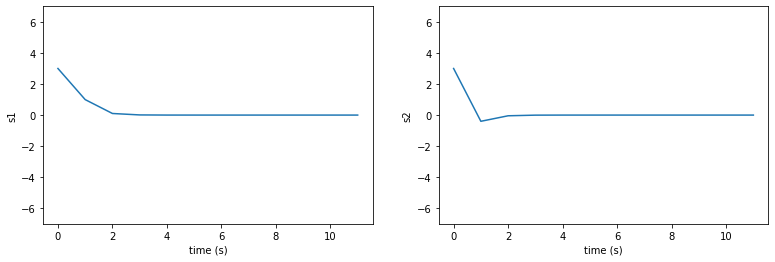

In [63]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.ylim(-7,7)
plt.xlabel('time (s)')
plt.ylabel('s1')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.ylim(-7,7)
plt.xlabel('time (s)')
plt.ylabel('s2')
plt.plot(time_log, states[:,1])